# Preprocesamiento EMNIST

- Reshape de 784 píxeles a matrices 28x28
- Normalización (invertir polaridad y escalar a [0, 1])
- Binarización por umbral de Otsu
- Extracción del ground truth en texto plano (usando el mapping de EMNIST)
- Uso del split original: 697,932 train / 116,323 test
- Extracción: 52 features (valentin)
- PCA 52 a 35-40 dimensiones (compensación de desbalance - class weight) 


## Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt
import pickle

In [2]:
train_path = "../data/emnist-byclass-train.csv"
test_path = "../data/emnist-byclass-test.csv"

## Cargamos dataset EMNIST
Cada archivo CSV tiene **785 columnas**:
- Columna 0: etiqueta (label numérico)
- Columnas 1...784: valores de píxel en escala de grises [0, 255]

In [3]:
train = pd.read_csv(train_path, header=None, dtype=np.uint8).values
test = pd.read_csv(test_path, header=None, dtype=np.uint8).values

print('Train shape:', train.shape)
print('Test shape :', test.shape)

Train shape: (697932, 785)
Test shape : (116323, 785)


## Función de preprocesamiento

Esta función realiza:
1. Separación de labels (ground truth) y píxeles
2. Reshape a imágenes 28x28
3. Inversión de polaridad y normalización a [0, 1]
4. Binarización Otsu por imagen

In [4]:
def preprocess_emnist(arr):
    """Preprocesa un array EMNIST (ByClass).

    Parámetros
    ----------
    arr : np.ndarray
        Array con shape (N, 785). Columna 0 = label.

    Devuelve
    --------
    X_bin_img : np.ndarray, shape (N, 28, 28)
        Imágenes binarizadas (0/1) en formato 2D.
    y : np.ndarray, shape (N,)
        Labels enteros.
    """
    # 1. Separar labels y píxeles
    y = arr[:, 0].astype(np.uint8, copy=False)
    X = arr[:, 1:].astype(np.uint8, copy=False)  # [0, 255]

    # 2. Reshape a (N, 28, 28)
    X_img = X.reshape(-1, 28, 28).astype(np.uint8, copy=False)

    # 3. Ajustar orientación oficial de EMNIST
    X_img = np.rot90(np.flip(X_img, axis=2), k=1, axes=(1, 2)).astype(np.uint8, copy=False)

    # 4. Invertir polaridad y normalizar
    # asumimos fondo blanco, letra negro
    X_inverted = 255 - X_img
    X_norm = X_inverted.astype(np.float32) / 255.0  # [0, 1]

    # 5. Binarización Otsu por imagen
    N = X_norm.shape[0]
    X_bin_img = np.empty_like(X_norm, dtype=np.uint8)

    for i in range(N):
        # umbral de Otsu en la imagen i
        thresh = threshold_otsu(X_norm[i])
        X_bin_img[i] = (X_norm[i] >= thresh).astype(np.uint8)

    return X_bin_img, y

## Ejecutar preprocesamiento en train y test

In [5]:
X_train, y_train = preprocess_emnist(train)
X_test, y_test  = preprocess_emnist(test)

print('Train binarizado:', X_train.shape, y_train.shape)
print('Test  binarizado:', X_test.shape, y_test.shape)

Train binarizado: (697932, 28, 28) (697932,)
Test  binarizado: (116323, 28, 28) (116323,)


In [6]:
class_mapping = dict(pd.read_csv('../data/emnist-byclass-mapping.txt', sep=r'\s+', header=None, names=['label', 'ascii']).sort_values('label').apply(lambda row: (int(row.label), chr(int(row.ascii))), axis=1).tolist())
with open('class_mapping.pkl', 'wb') as f:
    pickle.dump(class_mapping, f)

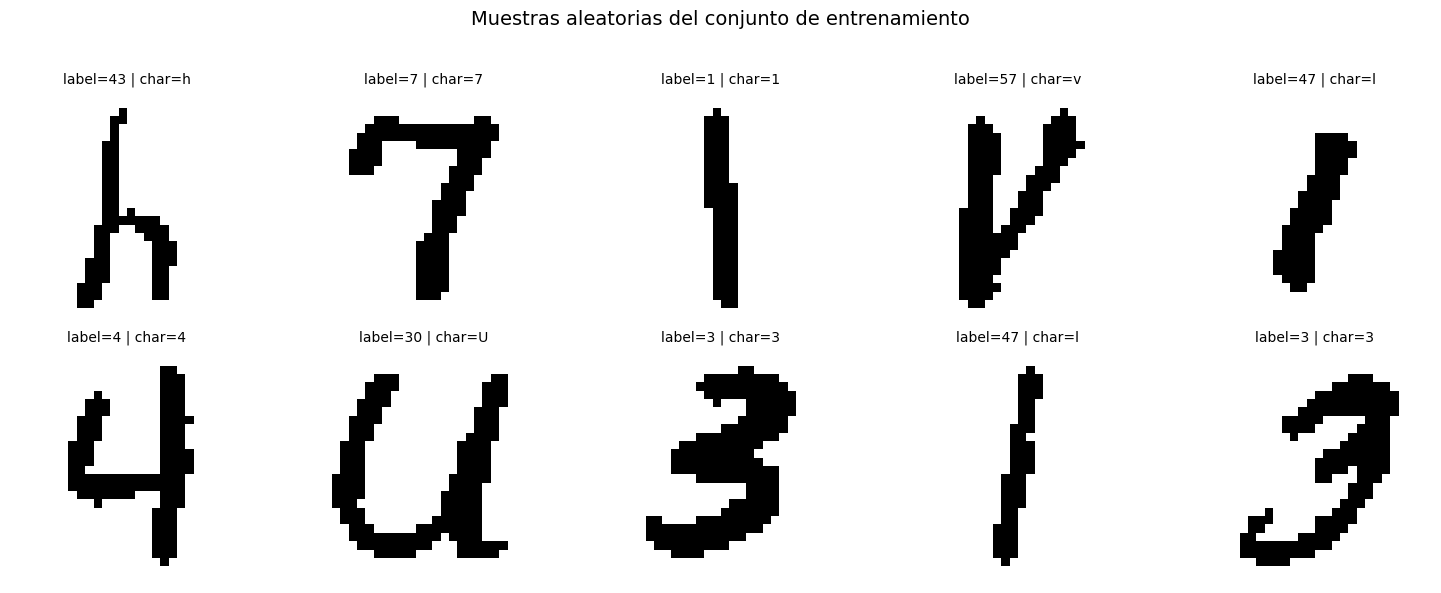

In [7]:
rng = np.random.default_rng(42)
sample_indices = rng.choice(len(y_train), size=10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for ax, idx in zip(axes.flatten(), sample_indices):
    ax.imshow(X_train[idx], cmap="gray")
    ax.set_title(f"label={y_train[idx]} | char={class_mapping[y_train[idx]]}", fontsize=10)
    ax.axis("off")

plt.suptitle("Muestras aleatorias del conjunto de entrenamiento", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [8]:
output_dir = Path("output")
output_dir.mkdir(parents=True, exist_ok=True)

np.savez_compressed(
    output_dir / "emnist_train_processed.npz",
    X_train=X_train,
    y_train=y_train
)
np.savez_compressed(
    output_dir / "emnist_test_processed.npz",
    X_test=X_test,
    y_test=y_test
)

print(f"Processed dataset saved in: {output_dir}/")

Processed dataset saved in: output/
